In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from propagation import laser
from propagation import plasma
from lens import profile
from lens import bessel
from lens import ray
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from numpy.fft import fft, ifft, fft2, ifft2, fftfreq, fftshift
from scipy.special import jn
from ht import intht
path = '/media/robert/Data_Storage/Data/Ionization/RayBesselMultiMode/100um_central/'
if not os.path.exists(path):
    os.makedirs(path)

In [2]:
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 35,
       'type' : 'gaussian'}
# Central intensity profile
z0 = 0.75e6
zf = 50e6
dz = 0.5e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I0 = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)
# Outer mode intensity profile
sigmaIn = 1e4
sigmaOut = 1e4
dz = 0.75e6
z1, I1 = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

I = [I0, I1]

In [3]:
# Lets test the function for creating these optical elements
# Caculate the unrefracted beams
prop = {'Nx' : 2**10,
        'Ny' : 2**9,
        'Nz' : 2**8,
        'X' : 20e3,
        'Y' : 20e3,
        'Z' : 2e6,
        'E0' : 1.0,
        'lam' : 0.8,
        'n' : 1.0
        }
params = {'L' : 2,
          'N' : 1000,
          'M' : 1000,
          'R' : 0.10e3,
          'lam' : 0.8,
          'rmax' : [30e3, 30e3],
          'rc' : [12e3],
          'r0' : [8e3],
          'w' : [2.65e3],
          'nGauss' : [8],
          'm' : [.51],
          'prop' : prop,
          'order' : [0, 4],
          'atom' : ionization.H2,
          'tau' : ion['tau'],
          'multi' : [0, 3.0],
          'xlim' : [-500, 500]
         }

# Temporal pulse
def Tfunc(t):
    from ionization import ionization
    tau = 35
    E = ionization.gaussian_envelope(1.0, t, tau).real
    E = E/np.amax(E)
    return E

plasmaPar = {'Nt' : 2**6,
             'T' : 100,
             'n0' : 0.25,
             'alpha' : 0.787,
             'EI' : 15.426
            }
refParams = {'seq' : [1, 0],
          'plasma' : plasmaPar
         }

name = '100um'
folder = name + 'Order_'+str(params['order'][1])+'_X'+str(params['multi'])+'/'
simPath = path+folder
if not os.path.exists(simPath):
    os.makedirs(simPath)
params['path'] = simPath
refParams['path'] = simPath

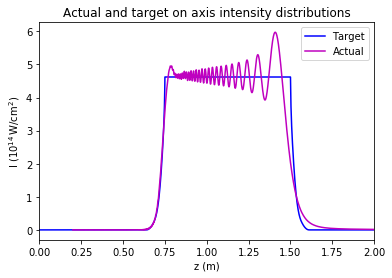

In [4]:
E, r = ray.super_gaussian_phase(params, I[1], z, 0)
# Fresnel propagate to see how well it works
zFres = z[200:2000]
Ediff = laser.fresnel_axis(E, r, zFres, params['lam'])
Idiff = ionization.intensity_from_field(Ediff)
# Shift everything by the average
Itot = integrate.simps(I[1])
Iact = integrate.simps(Idiff)
Idiff = Idiff * (Itot/Iact)
plt.plot(z/1e6, I[1], 'b', zFres/1e6, Idiff, 'm-')
plt.title('Actual and target on axis intensity distributions')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.legend(['Target', 'Actual'])
plt.xlim([0, 2])
plt.show()

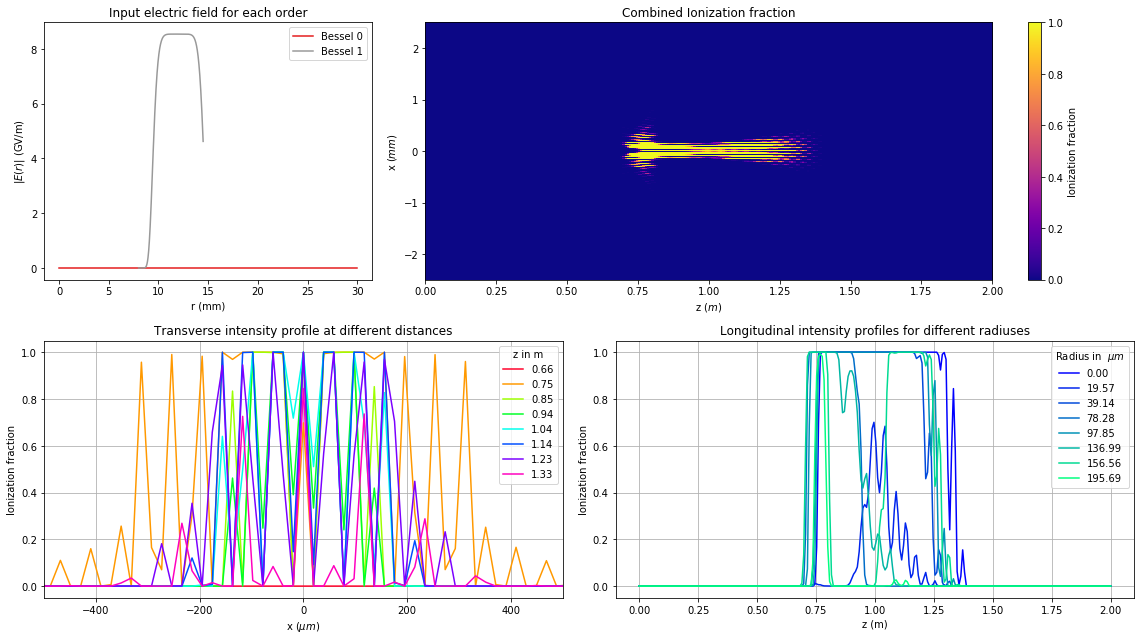

In [7]:
bessel.multimode_lens_ionization(params, z, I, diffI=True)
bessel.ionization_plot(params['path'], 8, dr=25)

In [6]:
#bessel.multimode_refraction(refParams, Tfunc)
data = simPath + 'Density-' + str(plasmaPar['n0']) + '_' + str(refParams['seq']) + \
                '/Bessel_' + str(refParams['seq'][-1]) +'/finalDensity.npy'
#bessel.ionization_plot(simPath, 6, dr=25, data=data, suffix='Refraction')